# Paradigm Free Mapping vs Total Activation: a comparison of the two methods

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pywt import wavedec
from scipy.signal import find_peaks
from scipy.stats import median_absolute_deviation
from sklearn.linear_model import lars_path

from Scripts.debiasing_int import debiasing_int as debiasing
from Scripts.fista_update import fista_update as fista
from Scripts.hrf_matrix import HRFMatrix
from Scripts.temporal_ta import filter_boundary as ta_filter
from Scripts.total_activation import total_activation as ta
from Scripts.total_activation import hrf_filters

## Load data

In [2]:
data_type = 'long' # choose among 'short', 'long' and 'mix'
data = np.load(f'data/simulation_data_{data_type}.npy')
ground_truth = np.load(f'data/simulation_bold_{data_type}.npy')[:, 0]
nscans = data.shape[0]
nvoxels = data.shape[1]
print(f'Data has {nscans} scans and {nvoxels} voxels')

Data has 300 scans and 8 voxels


## Data parameters

In [3]:
params = {'tr': 2, 'cost_save': True, 'te': [0]}

## Runs spike model PFM and TA on every voxel

It runs LARS on PFM first, then uses the lambdas from LARS on TA.

In [4]:
# Generate design matrix (shifted HRFs) for PFM with the spike model
hrf_matrix = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')
hrf_matrix.generate_hrf()
hrf = hrf_matrix.X_hrf_norm

# Generate hrf filter for TA with spike model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

nlambdas = nscans

for vox_idx in range(1): #range(nvoxels):
    print(f'Running LARS for PFM on voxel {vox_idx + 1} of {nvoxels}...')
    
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    # LARS path
    lambdas_pfm_spike, _, pfm_spike_coef_path = lars_path(hrf, np.squeeze(y), method = 'lasso', Gram = np.dot(hrf.T, hrf),
                                                          Xy = np.dot(hrf.T, np.squeeze(y)), max_iter = nlambdas-1, eps=1e-9)
    # Residuals
    L2res_pfm = np.sum(abs(np.repeat(y, nlambdas, axis=-1) - pfm_spike_coef_path), axis=1)
    bic_pfm_spike = nscans*np.log10(L2res_pfm) + np.log10(nscans)*np.count_nonzero(pfm_spike_coef_path, axis=0)
    aic_pfm_spike = nscans*np.log10(L2res_pfm) + 2*np.count_nonzero(pfm_spike_coef_path, axis=0)
    
    # Calculates regularization path for TA
    print(f'Calculating regularization path for TA on voxel {vox_idx + 1} of {nvoxels}...')
    ta_max_lambda = np.max(ta_filter(n, d, y, 'transpose', nscans))
    lambdas_ta_spike = np.geomspace(ta_max_lambda, 0.1*ta_max_lambda, nlambdas)
    ta_spike_coef_path = np.zeros(pfm_spike_coef_path.shape) # Shape: nscans x nlambdas
    for lambda_idx in range(nlambdas):
        ta_spike_coef_path[:, lambda_idx] = np.squeeze(ta(y, params, lambd=lambdas_ta_spike[lambda_idx]))
    
    # Residuals
    L2res_ta = np.sum(abs(np.repeat(y, nlambdas, axis=-1) - ta_spike_coef_path), axis=1)
    bic_ta_spike = nscans*np.log10(L2res_ta) + np.log10(nscans)*np.count_nonzero(ta_spike_coef_path, axis=0)
    aic_ta_spike = nscans*np.log10(L2res_ta) + 2*np.count_nonzero(ta_spike_coef_path, axis=0)
    
    print(f'Regularization path of voxel {vox_idx + 1} calculated')
    
bic_pfm_spike_idx = np.argmin(bic_pfm_spike)
aic_pfm_spike_idx = np.argmin(aic_pfm_spike)
bic_ta_spike_idx = np.argmin(bic_ta_spike)
aic_ta_spike_idx = np.argmin(aic_ta_spike)

/Users/enekourunuela/pySPFM/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Running LARS for PFM on voxel 1 of 8...
Calculating regularization path for TA on voxel 1 of 8...
Regularization path of voxel 1 calculated


## Plot comparison of spike model regularization path

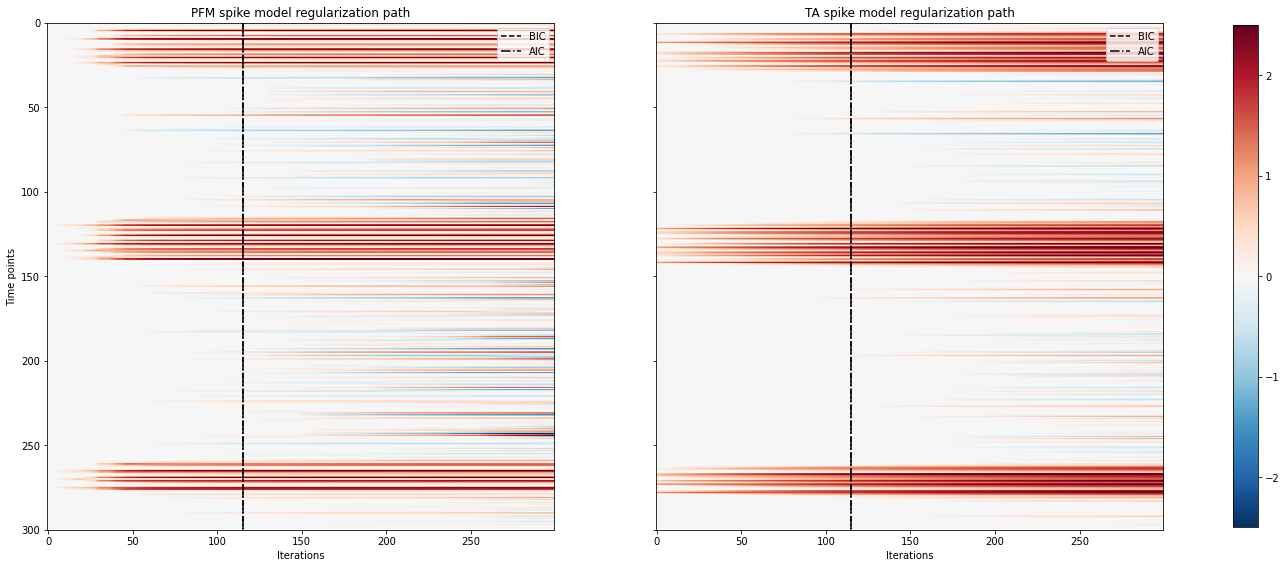

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,12))
im = ax1.imshow(pfm_spike_coef_path, cmap='RdBu_r', vmin=-2.5, vmax=2.5)
ax1.vlines(x=bic_pfm_spike_idx, ymin=0, ymax=nlambdas, color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_spike_idx, ymin=0, ymax=nlambdas, color='black', linestyles='dashdot', label='AIC')
ax1.set_ylim([300, 0])
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Time points')
ax1.set_title('PFM spike model regularization path')
ax2.imshow(ta_spike_coef_path, cmap='RdBu_r', vmin=-2.5, vmax=2.5)
ax2.vlines(x=bic_ta_spike_idx, ymin=0, ymax=nlambdas, color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_spike_idx, ymin=0, ymax=nlambdas, color='black', linestyles='dashdot', label='AIC')
ax2.set_ylim([300, 0])
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA spike model regularization path')
fig.colorbar(im, ax=[ax1, ax2], shrink=0.77)

Text(0.5, 1.0, 'TA spike model lambdas')

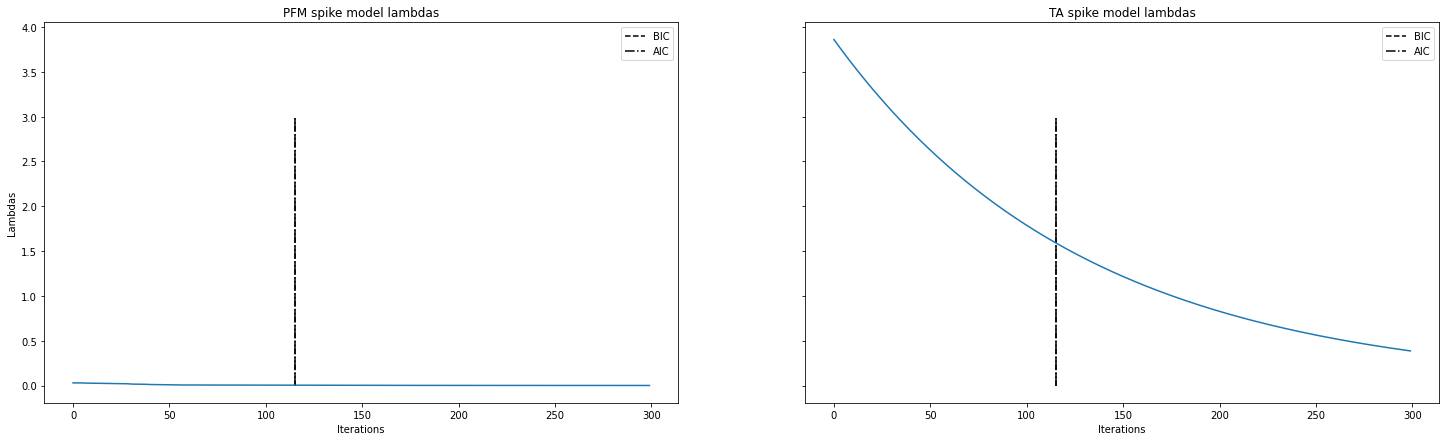

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))
ax1.plot(lambdas_pfm_spike)
ax1.vlines(x=bic_pfm_spike_idx, ymin=0, ymax=3, color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_spike_idx, ymin=0, ymax=3, color='black', linestyles='dashdot', label='AIC')
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Lambdas')
ax1.set_title('PFM spike model lambdas')
ax2.plot(lambdas_ta_spike)
ax2.vlines(x=bic_ta_spike_idx, ymin=0, ymax=3, color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_spike_idx, ymin=0, ymax=3, color='black', linestyles='dashdot', label='AIC')
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA spike model lambdas')

Text(0.5, 1.0, 'BIC & AIC for TA with spikes')

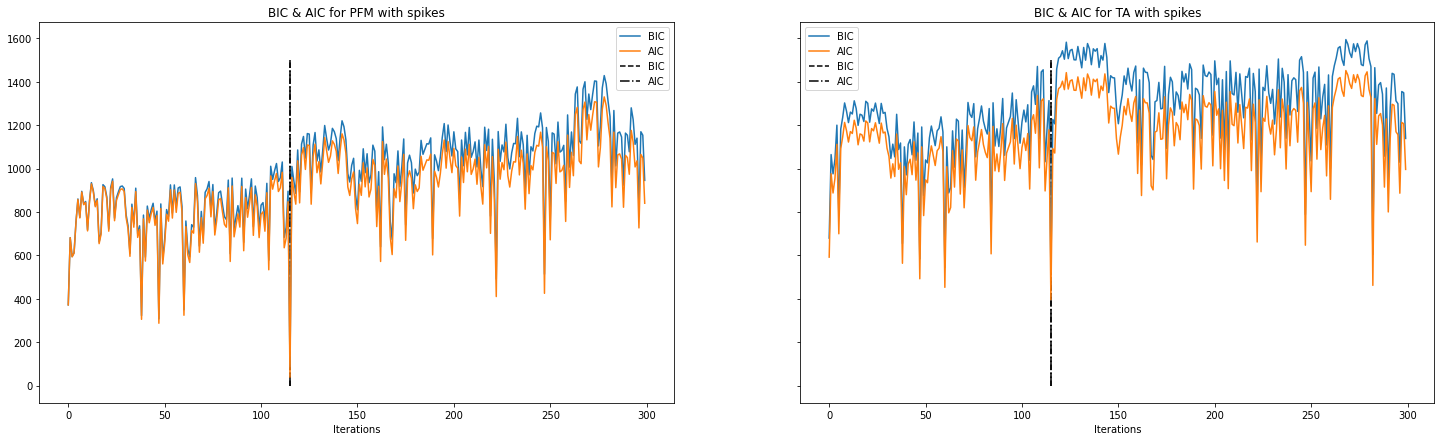

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))
ax1.plot(bic_pfm_spike, label='BIC')
ax1.plot(aic_pfm_spike, label='AIC')
ax1.vlines(x=bic_pfm_spike_idx, ymin=0, ymax=1500, color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_spike_idx, ymin=0, ymax=1500, color='black', linestyles='dashdot', label='AIC')
ax1.set(xlabel='Iterations')
ax1.set_title('BIC & AIC for PFM with spikes')
ax1.legend()
ax2.plot(bic_ta_spike, label='BIC')
ax2.plot(aic_ta_spike, label='AIC')
ax2.vlines(x=bic_ta_spike_idx, ymin=0, ymax=1500, color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_spike_idx, ymin=0, ymax=1500, color='black', linestyles='dashdot', label='AIC')
ax2.set(xlabel='Iterations')
ax2.legend()
ax2.set_title('BIC & AIC for TA with spikes')

## Runs block model PFM and TA on every voxel

In [8]:
# Generate design matrix (shifted HRFs) for PFM with the block model
hrf_matrix = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=True, is_afni=True, lop_hrf='SPMG1')
hrf_matrix.generate_hrf()
hrf = hrf_matrix.X_hrf_norm

# Generate hrf filter for TA with block model
params['model'] = 'block'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

nlambdas = nscans

for vox_idx in range(1): #range(nvoxels):
    print(f'Running LARS for PFM on voxel {vox_idx + 1} of {nvoxels}...')
    
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    # LARS path
    lambdas_pfm_block, _, pfm_block_coef_path = lars_path(hrf, np.squeeze(y), method = 'lasso', Gram = np.dot(hrf.T, hrf),
                                                          Xy = np.dot(hrf.T, np.squeeze(y)), max_iter = nlambdas-1, eps=1e-9)
    # Residuals
    L2res_pfm = np.sum(abs(np.repeat(y, nlambdas, axis=-1) - pfm_block_coef_path), axis=1)
    bic_pfm_block = nscans*np.log10(L2res_pfm) + np.log10(nscans)*np.count_nonzero(pfm_block_coef_path, axis=0)
    aic_pfm_block = nscans*np.log10(L2res_pfm) + 2*np.count_nonzero(pfm_block_coef_path, axis=0)
    
    # Calculates regularization path for TA
    print(f'Calculating regularization path for TA on voxel {vox_idx + 1} of {nvoxels}...')
    ta_max_lambda = np.max(ta_filter(n, d, y, 'transpose', nscans))
    lambdas_ta_block = np.geomspace(ta_max_lambda, 0.1*ta_max_lambda, nlambdas)
    ta_block_coef_path = np.zeros(pfm_block_coef_path.shape) # Shape: nscans x nlambdas
    for lambda_idx in range(nlambdas):
        ta_block_coef_path[:, lambda_idx] = np.squeeze(ta(y, params, lambd=lambdas_ta_block[lambda_idx]))
    
    # Residuals
    L2res_ta = np.sum(abs(np.repeat(y, nlambdas, axis=-1) - ta_block_coef_path), axis=1)
    bic_ta_block = nscans*np.log10(L2res_ta) + np.log10(nscans)*np.count_nonzero(ta_block_coef_path, axis=0)
    aic_ta_block = nscans*np.log10(L2res_ta) + 2*np.count_nonzero(ta_block_coef_path, axis=0)
    
    print(f'Regularization path of voxel {vox_idx + 1} calculated')

/Users/enekourunuela/pySPFM/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))


Running LARS for PFM on voxel 1 of 8...
Calculating regularization path for TA on voxel 1 of 8...
Regularization path of voxel 1 calculated


In [9]:
bic_pfm_block_idx = np.argmin(bic_pfm_block)
aic_pfm_block_idx = np.argmin(aic_pfm_block)
bic_ta_block_idx = np.argmin(bic_ta_block)
aic_ta_block_idx = np.argmin(aic_ta_block)

In [10]:
"""
hrf_matrix = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')
hrf_matrix.generate_hrf()
hrf = hrf_matrix.X_hrf_norm

pfm_block_coef_path_final = np.zeros((pfm_block_coef_path.shape))

# Only keep peaks
for lambda_idx in range(nlambdas):
    pfm_block = np.squeeze(pfm_block_coef_path[:, lambda_idx])
    peak_idxs, _ = find_peaks(pfm_block, prominence=np.max(pfm_block)*0.01, distance=5)
    temp = np.zeros((pfm_block.shape[0],))
    temp[peak_idxs] = pfm_block[peak_idxs].copy()

    temp_final, _ = debiasing(temp, hrf, y, is_ls=True)
    pfm_block_coef_path_final[:, lambda_idx] = np.squeeze(temp_final) """

"\nhrf_matrix = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')\nhrf_matrix.generate_hrf()\nhrf = hrf_matrix.X_hrf_norm\n\npfm_block_coef_path_final = np.zeros((pfm_block_coef_path.shape))\n\n# Only keep peaks\nfor lambda_idx in range(nlambdas):\n    pfm_block = np.squeeze(pfm_block_coef_path[:, lambda_idx])\n    peak_idxs, _ = find_peaks(pfm_block, prominence=np.max(pfm_block)*0.01, distance=5)\n    temp = np.zeros((pfm_block.shape[0],))\n    temp[peak_idxs] = pfm_block[peak_idxs].copy()\n\n    temp_final, _ = debiasing(temp, hrf, y, is_ls=True)\n    pfm_block_coef_path_final[:, lambda_idx] = np.squeeze(temp_final) "

## Plot comparison of block model regularization path

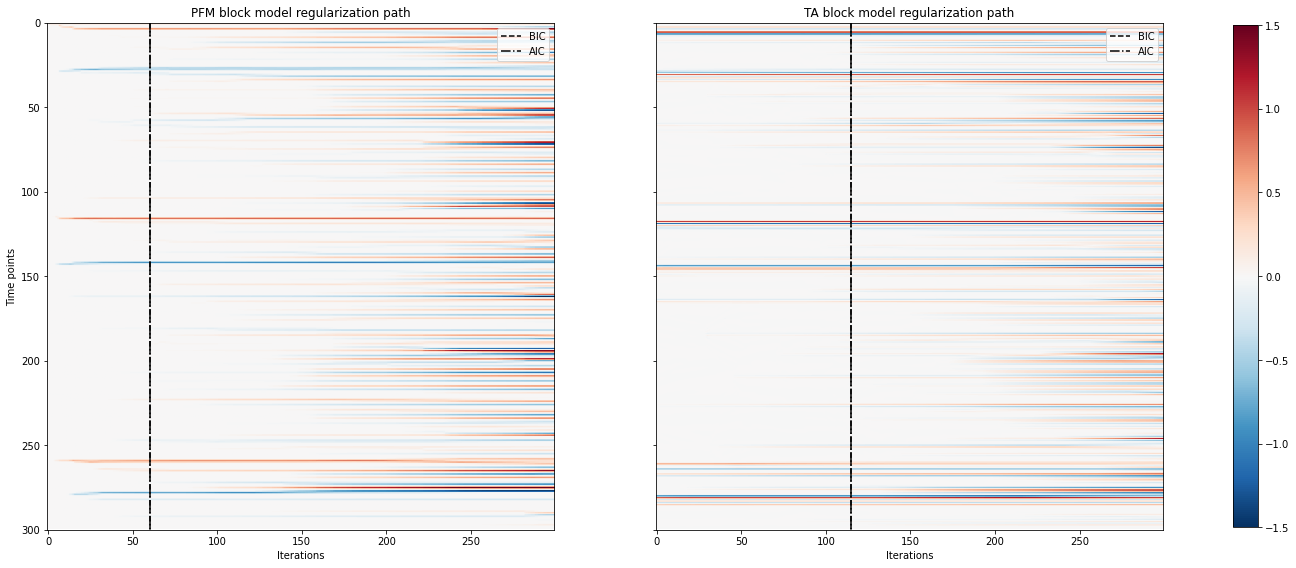

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,12))
im = ax1.imshow(pfm_block_coef_path, cmap='RdBu_r', vmin=-1.5, vmax=1.5)
ax1.vlines(x=bic_pfm_block_idx, ymin=0, ymax=nlambdas, color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_block_idx, ymin=0, ymax=nlambdas, color='black', linestyles='dashdot', label='AIC')
ax1.set_ylim([300, 0])
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Time points')
ax1.set_title('PFM block model regularization path')
ax2.imshow(ta_block_coef_path, cmap='RdBu_r', vmin=-1.5, vmax=1.5)
ax2.vlines(x=bic_ta_block_idx, ymin=0, ymax=nlambdas, color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_block_idx, ymin=0, ymax=nlambdas, color='black', linestyles='dashdot', label='AIC')
ax2.set_ylim([300, 0])
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA block model regularization path')
fig.colorbar(im, ax=[ax1, ax2], shrink=0.77)

Text(0.5, 1.0, 'TA block model lambdas')

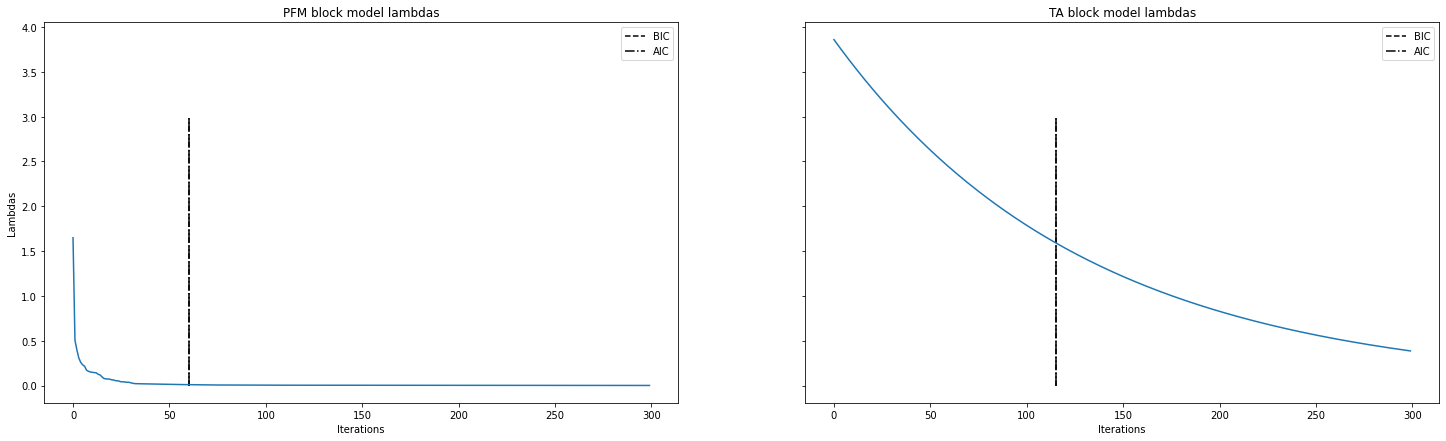

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))
ax1.plot(lambdas_pfm_block)
ax1.vlines(x=bic_pfm_block_idx, ymin=0, ymax=3, color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_block_idx, ymin=0, ymax=3, color='black', linestyles='dashdot', label='AIC')
ax1.legend()
ax1.set(xlabel='Iterations', ylabel='Lambdas')
ax1.set_title('PFM block model lambdas')
ax2.plot(lambdas_ta_block)
ax2.vlines(x=bic_ta_block_idx, ymin=0, ymax=3, color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_block_idx, ymin=0, ymax=3, color='black', linestyles='dashdot', label='AIC')
ax2.legend()
ax2.set(xlabel='Iterations')
ax2.set_title('TA block model lambdas')

Text(0.5, 1.0, 'BIC & AIC for TA with blocks')

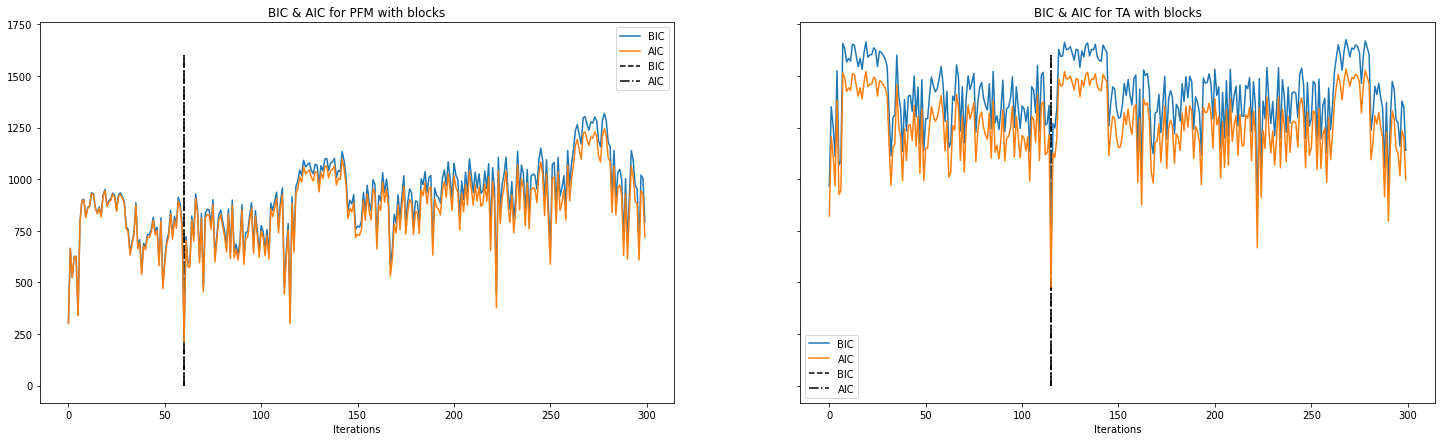

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))
ax1.plot(bic_pfm_block, label='BIC')
ax1.plot(aic_pfm_block, label='AIC')
ax1.vlines(x=bic_pfm_block_idx, ymin=0, ymax=1600, color='black', linestyles='dashed', label='BIC')
ax1.vlines(x=aic_pfm_block_idx, ymin=0, ymax=1600, color='black', linestyles='dashdot', label='AIC')
ax1.set(xlabel='Iterations')
ax1.set_title('BIC & AIC for PFM with blocks')
ax1.legend()
ax2.plot(bic_ta_block, label='BIC')
ax2.plot(aic_ta_block, label='AIC')
ax2.vlines(x=bic_ta_block_idx, ymin=0, ymax=1600, color='black', linestyles='dashed', label='BIC')
ax2.vlines(x=aic_ta_block_idx, ymin=0, ymax=1600, color='black', linestyles='dashdot', label='AIC')
ax2.set(xlabel='Iterations')
ax2.legend()
ax2.set_title('BIC & AIC for TA with blocks')

## PFM vs TA with noise estimate and updating lambda (spike model)

In [14]:
# Generate design matrix (shifted HRFs) for PFM with the block model
hrf_matrix = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')
hrf_matrix.generate_hrf()
hrf = hrf_matrix.X_hrf_norm

# Generate hrf filter for TA with block model
params['model'] = 'spike'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

nlambdas = nscans

for vox_idx in range(1):
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    _, cD1 = wavedec(y, 'db3', level=1, axis=0)
    noise_estimate = np.median(abs(cD1 - np.median(cD1))) / 0.8095
    
    pfm_spikes, _ = fista(hrf, y, max_iter=50, lambd=noise_estimate, update_lambda=True)
    ta_spikes = ta(y, params, lambd=noise_estimate, update_lambda=True)

/Users/enekourunuela/pySPFM/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))
/Users/enekourunuela/pySPFM/Scripts/fista_update.py:8: RuntimeWarning: divide by zero encountered in true_divide
  x = y*np.maximum(np.zeros(y.shape), 1-(weights*lambd/abs(y)))


Text(0.5, 1.0, 'TA spike model with noise estimation')

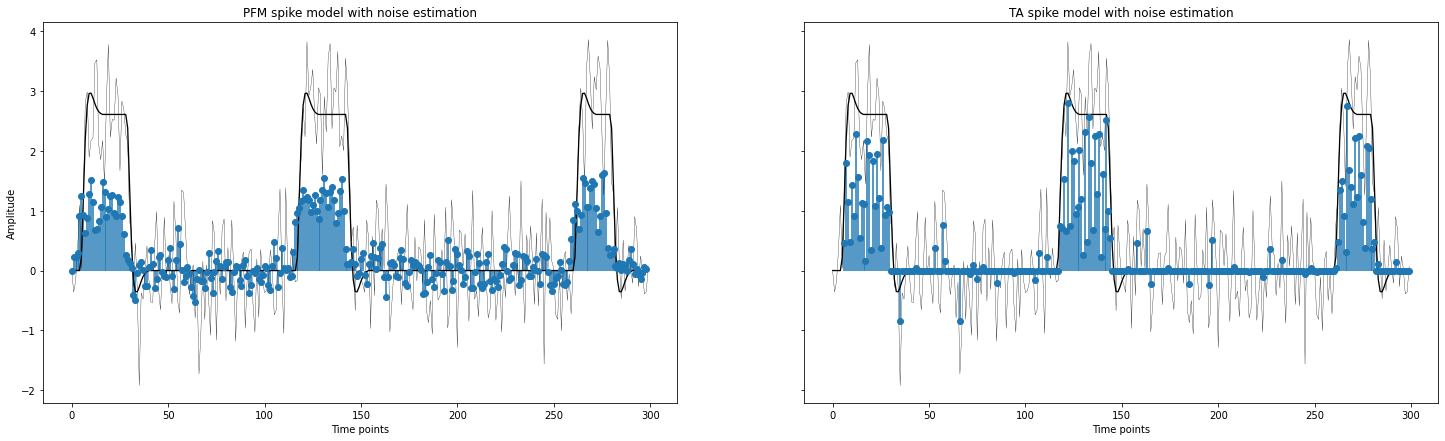

In [15]:
pfm_spikes_plot = pfm_spikes.copy()
pfm_spikes_plot[pfm_spikes_plot == 0] = np.nan
ta_spikes_plot = ta_spikes.copy()
ta_spikes_plot[ta_spikes_plot == 0] = np.nan

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))
ax1.plot(y, color='black', linewidth=.3, label='Simulation')
ax1.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax1.stem(pfm_spikes_plot, label='PFM', use_line_collection=True, basefmt=" ")
ax1.set(xlabel='Time points', ylabel='Amplitude')
ax1.set_title('PFM spike model with noise estimation')
ax2.plot(y, color='black', linewidth=.3, label='Simulation')
ax2.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax2.stem(ta_spikes_plot, label='TA', use_line_collection=True, basefmt=" ")
ax2.set(xlabel='Time points')
ax2.set_title('TA spike model with noise estimation')

## PFM vs TA with noise estimate and updating lambda (block model)

In [16]:
# Generate design matrix (shifted HRFs) for PFM with the block model
hrf_matrix = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=True, is_afni=True, lop_hrf='SPMG1')
hrf_matrix.generate_hrf()
hrf = hrf_matrix.X_hrf_norm

# Generate hrf filter for TA with block model
params['model'] = 'block'
params['f_analyze'], params['f_recons'], params['maxeig'] = hrf_filters(params['tr'], condition=params['model'])
n = params['f_analyze']['num']
d = params['f_analyze']['den']

nlambdas = nscans

for vox_idx in range(1):
    y = data[:, vox_idx]
    y = y[:, np.newaxis]
    
    _, cD1 = wavedec(y, 'db3', level=1, axis=0)
    noise_estimate = np.median(abs(cD1 - np.median(cD1))) / 0.8095
    
    pfm_block, _ = fista(hrf, y, max_iter=100, lambd=noise_estimate, update_lambda=True, precision=1e-3)
    ta_block = ta(y, params, lambd=noise_estimate, update_lambda=True)

# Only keep peaks
pfm_block = np.squeeze(pfm_block)
peak_idxs, _ = find_peaks(abs(pfm_block), prominence=np.max(pfm_block)*0.01, distance=5)
temp = np.zeros((pfm_block.shape[0],))
temp[peak_idxs] = pfm_block[peak_idxs].copy()

hrf_matrix = HRFMatrix(TR=params['tr'], TE=params['te'], nscans=nscans, r2only=True, has_integrator=False, is_afni=True, lop_hrf='SPMG1')
hrf_matrix.generate_hrf()
hrf = hrf_matrix.X_hrf_norm

pfm_block_final, _ = debiasing(temp, hrf, y, is_ls=True)

/Users/enekourunuela/pySPFM/Scripts/total_activation.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  fil[i + 1] = (-1) ** (i + 1) * np.sum(np.exp(np.sum(combs_result, axis=1)))
/Users/enekourunuela/pySPFM/Scripts/fista_update.py:8: RuntimeWarning: divide by zero encountered in true_divide
  x = y*np.maximum(np.zeros(y.shape), 1-(weights*lambd/abs(y)))


Text(0.5, 1.0, 'TA block model with noise estimation')

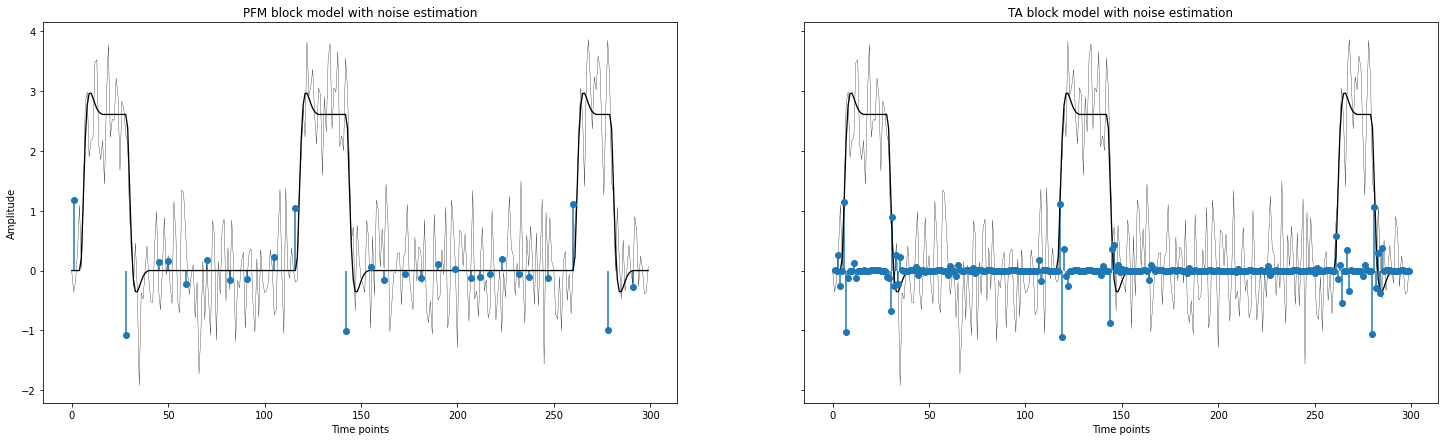

In [17]:
temp[temp == 0] = np.nan
ta_block_plot = ta_block.copy()
ta_block_plot[ta_block_plot == 0] = np.nan

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25,7))
ax1.plot(y, color='black', linewidth=.3, label='Simulation')
ax1.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax1.stem(10*temp, label='PFM', use_line_collection=True, basefmt=" ")
#ax1.plot(10*temp, linewidth=2, label='PFM', color='#FF7E02')
ax1.set(xlabel='Time points', ylabel='Amplitude')
ax1.set_title('PFM block model with noise estimation')
ax2.plot(y, color='black', linewidth=.3, label='Simulation')
ax2.plot(ground_truth, color='black', linewidth='1.3', label='Ground truth')
ax2.stem(ta_block_plot, label='PFM', use_line_collection=True, basefmt=" ")
#ax2.plot(ta_block_plot, linewidth=2, label='TA', color='#FF7E02')
ax2.set(xlabel='Time points')
ax2.set_title('TA block model with noise estimation')